# NSGConstantQ Examples

This notebook provides practical examples of using the NSGConstantQ algorithm.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from essentia import Pool
from essentia import run
import essentia.streaming as streaming
import essentia.standard as standard

%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 6.0)
eps = np.finfo(np.float64).eps

## Configuring the algorithm 
In this example the algorithm is configured to analyse a fragment of male singing voice. The frequency range we want to analyze is set accordingly. The minimum frequency is set to match the freqeuncy of a note (C2 in this case). The `binsPerOctave` is set to a miltiple of 12 so that the frequency channels (bands) we want to compute match subdivisions of an equal tempered scale (in our case, 4 bins per semitone).

`rasterize` controls the interpolation on the frequency channels. When set to 'full', frequency channels will have the same lengths. The 'full' interpolation is mandatory if one wants to stream frames in the streaming mode.

If one wants to perform transformations in the constant-Q domain and then go back to the time domain, both direct and inverse algorithms (NSGConstantQ and NSGIConstantQ) should be configured with exactly the same parameters. The easiest way to do this is to use a dictionary for configuring both algorithms' parameters.

In [2]:
kwargs = {
'inputSize': 4096,
'minFrequency': 65.41,
'maxFrequency': 6000,
'binsPerOctave': 48,
'sampleRate': 44100,
'rasterize': 'full',
'phaseMode': 'global',
'gamma': 0,
'normalize': 'none',
'window': 'hannnsgcq',
}

## Standard mode
Standard mode is very simple to use. In this example we transform a singing voice into the Gabor domain and then compute back its time representation. It is important to configure both algorithms with the same parameters. It is especially important to set `inputSize` so that the inverse algorithm is able to reconstruct the input signal.

In [6]:
x = standard.MonoLoader(filename = '../../../test/audio/recorded/vignesh.wav')()[:-1] 
# Remove the last sample to make the signal even

kwargs['inputSize'] = len(x)

CQStand = standard.NSGConstantQ(**kwargs)
CQIStand = standard.NSGIConstantQ(**kwargs)

constantq, dcchannel, nfchannel = CQStand(x)
y = CQIStand(constantq, dcchannel, nfchannel)

NSGConstantQ outputs three vectors. The first one (``constantq``) is the actual transform and it is a complex time-frequency representation of the input audio. Depending on the `rasterize` parameter it will behave differently:

- 'none': each frequency channel will have the minimum length needed give full frequency support to its bandwidth. The ``constantq`` output is a list of lists. 
- 'piecewise': adds some interpolation to make the length of each channel a power of 2 in order to perform optimized FFTs.
- 'full': interpolates the channels so that they all have the same length and the ``constantq`` output is a square matrix (i.e., a 2D complex numpy matrix). This may be the easiest way to manipulate the data afterwards. 

The other two outputs (``dcchannel`` and ``mfchannel``) are only important in order to compute the inverse transform.

### Constant-Q spectrogram
Finally, let's see how our transform looks like. As the ``constantq`` variable is a complex 2D matrix, we compute its absolute values and then apply log-transform to obtain the log-spectrogram.

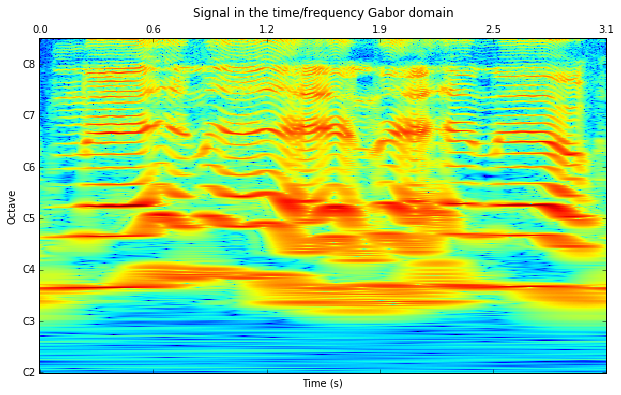

In [10]:
# Time labeling
ticksTime = np.linspace(0, len(constantq.T), 6)
secs = np.around(ticksTime * kwargs['inputSize'] /  (kwargs['sampleRate'] * len(constantq.T) ) , decimals=1)
# Octave labeling
ticksFreq = np.arange(0,len(constantq),kwargs['binsPerOctave'])
notes =  ['C%i' %f for f in range(2, len(ticksFreq) +2, 1) ]

plt.matshow(np.log(np.abs(constantq)),origin='lower')
plt.yticks(ticksFreq, notes)
plt.xticks(ticksTime, secs)
plt.ylabel('Octave')
plt.xlabel('Time (s)')
plt.title('Signal in the time/frequency Gabor domain')
plt.show()

### Reconstructed signal

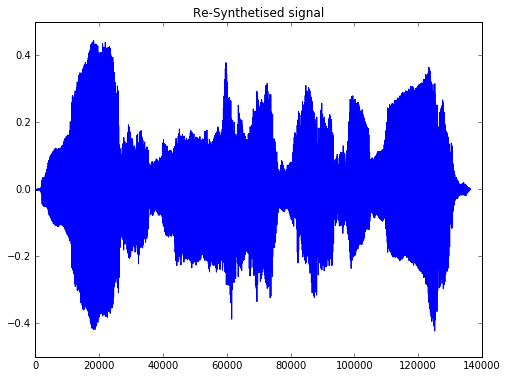

Synthesis SNR: 137.906 dB


In [9]:
plt.plot(y)
plt.title('Re-Synthetised signal')
plt.show()

SNR = np.mean(20*np.log10(np.abs(x[100:-100])/np.abs(x[100:-100]-y[100:-100] + eps) + eps))
print 'Synthesis SNR: %.3f dB' %SNR

Last time this script was executed, the maximun difference between the original and the sinthetized signal was 1.7883e-07. Provided that Essentia analysis is performed using 32-byte floats (eps = 1.192-07), this lets the systhesis error in the range of the numerical error. Thus, it can be considered a theoretically perfect reconstruction.

## Streaming mode

Now let's reimplement the same example in the streaming mode. Here we will also perform a frame-wise analysis, suitable for a real-time implementation.

First, let's instantiate the algorithms needed for the frame-wise analysis. We are using ``CartesianToPolar`` to save magnitude and phase values to a Pool (as it is currently not possible to save complex arrays to Essentia's pools).

In [14]:
kwargs['inputSize'] = 4096 

CQAlgo = streaming.NSGConstantQStreaming(**kwargs)
ICQAlgo = streaming.NSGIConstantQ(**kwargs)
loader = streaming.MonoLoader(filename='../../../test/audio/recorded/vignesh.wav')
w = streaming.Windowing(type='triangular',normalized=False, zeroPhase=False)
frameCutter = streaming.FrameCutter(frameSize=kwargs['inputSize'], hopSize=kwargs['inputSize']/2)

CQc2p = streaming.CartesianToPolar()
DCc2p = streaming.CartesianToPolar()
NFc2p = streaming.CartesianToPolar()

pool = Pool()

Let's run the network and save the data to the pool. The actual transform is sent through the ``constantq`` source. It is the only output needed for the analysis purposes. However, if the goal is to modify it and go back to the time domain, two extra outputs, containing the DC and the Nyquist channels, are required. These outputs contain the information below and above the analysis range and are required for the reconstruction of the signal. Additionally, a vector called 'framestamps' is returned in order to facilitate the reconstruction of the data. 

- ´constantq´ shape is ( timestamps , number of channels ) 
- ´constantqdc´ shape is ( framestamps , length of th DC channel )
- ´constantqnf´ shape is ( framestamps , length of th Nyquist channel )
- ´framestamps´ shape is ( framestamps )

Framewise vectors are returned once per call. Timewise vectores are returned more than one token per call and their number depends on the configuration parameters. Using these matrices may be confusing, as the original algorithm (on which our implementation is based) was not intended for real-time processing. 

In [15]:
# Conecting the algorithms
loader.audio >> frameCutter.signal

frameCutter.frame >> w.frame >> CQAlgo.frame

CQAlgo.constantq >> CQc2p.complex
CQAlgo.constantqdc >> DCc2p.complex
CQAlgo.constantqnf >> NFc2p.complex
CQAlgo.framestamps >> (pool, 'frameStamps')

CQc2p.magnitude >> (pool, 'CQmag')
CQc2p.phase >> (pool, 'CQphas')

DCc2p.magnitude >> (pool, 'DCmag')
DCc2p.phase >> (pool, 'DCphas')

NFc2p.magnitude >> (pool, 'NFmag')
NFc2p.phase >> (pool, 'NFphas')

run(loader)

### Plotting the transform



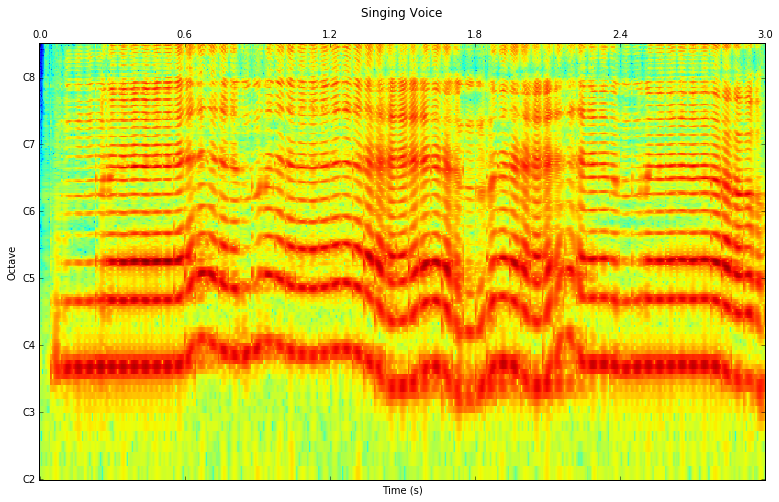

In [16]:
# Time labeling
ticksTime = np.linspace(0, len(pool['CQmag']), 6)
secs = np.around(ticksTime * kwargs['inputSize'] / (2 * kwargs['sampleRate'] * pool['frameStamps'][1] ), decimals=1)

# Octave labeling
ticksFreq = np.arange(0,len(pool['CQmag'].T),kwargs['binsPerOctave'])
notes =  ['C%i' %f for f in range(2, len(ticksFreq) +2, 1) ]


f, ax = plt.subplots(1, figsize = (13,10))
ax.matshow(np.log(pool['CQmag'].T),origin='lower', aspect=2)
plt.yticks(ticksFreq, notes)
plt.xticks(ticksTime, secs)
plt.ylabel('Octave')
plt.xlabel('Time (s)')
plt.title('Singing Voice')
plt.show()

In [18]:
# Using the same arguments for inverse transformation as for the analysis
ICQAlgo = standard.NSGIConstantQ(**kwargs)

# Loop to store the frames. DC and Nyquist channels are just tranformed into cartesian coordinates again. 
recFrame = [] 
for i in range(len(pool['DCmag'])-1):
    invDC = standard.PolarToCartesian()(pool['DCmag'][i], pool['DCphas'][i])
    invNF = standard.PolarToCartesian()(pool['NFmag'][i], pool['NFphas'][i])
    
    # Concatenate CQ frames. Here it is done using the 'frameStamp' vector.  
    invCQ = []
    for j in range(pool['frameStamps'][i], pool['frameStamps'][i+1],1):
        invCQ.append(standard.PolarToCartesian()(pool['CQmag'][j], pool['CQphas'][j]))
    
    # A trick to transpose a list of lists.  
    invCQlist = [list(x) for x in zip(*invCQ)]
    
    # The actual inverse transform. 
    recFrame.append(ICQAlgo(invCQlist, invDC, invNF))


# Overlaped addition of the input 
frameSize = kwargs['inputSize']
    
y = recFrame[0]

invWindow = standard.Windowing(type='triangular',normalized=False, zeroPhase=False)(standard.essentia.array(np.ones(frameSize)))


for i in range(1,len(recFrame)):
    y = np.hstack([y,np.zeros(frameSize/2)])
    y[-frameSize:] = y[-frameSize:] + recFrame[i] 
    
y = y[frameSize/2:]

### Reconstruction from Pool in standard mode

This is ugliest cell of this notebook! It shows how to return to the time domain from the constant-Q transform data stored in the pool using the standard mode again.

We can compare the original and the synthetised signals and compute the SNR of the algorithm

SNR: 137.799 dB


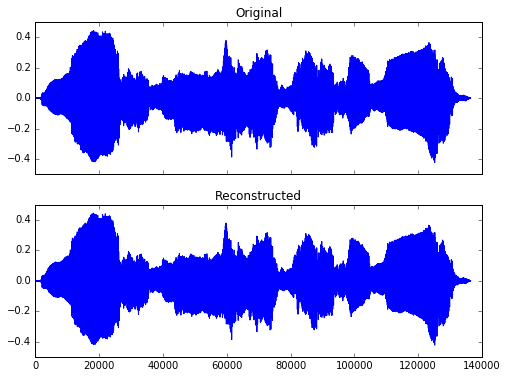

In [17]:
x = standard.MonoLoader(filename = '../../../test/audio/recorded/vignesh.wav')()
xtest = x[:len(y)]

SNR = np.mean(20*np.log10(np.abs(xtest)/np.abs(xtest-y + eps) + eps))
print 'SNR: %.3f dB' %SNR

_, ax = plt.subplots(2, sharex=True)
ax[0].plot(xtest)
ax[0].set_title('Original')
ax[1].plot(y)
ax[1].set_title('Reconstructed')
plt.show()